In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

np.random.seed(1)

In [2]:
def normalize(x):
    return np.array(x) / (3000)

## Create NDVI Filtered Dataset

In [111]:
train_data_dir = '../data/training_sites'

with open(os.path.join(train_data_dir, "negative_data_toa.pkl"), 'rb') as file:
    x_negative = np.array(pickle.load(file))

with open(os.path.join(train_data_dir, "bootstrap_data_toa.pkl"), 'rb') as file:
    x_negative_bootstrap = np.array(pickle.load(file))
    
x_negative = np.concatenate((x_negative, x_negative_bootstrap))
y_negative = np.zeros(len(x_negative))

with open(os.path.join(train_data_dir, "positive_data_toa.pkl"), 'rb') as file:
    x_positive = np.array(pickle.load(file))

with open(os.path.join(train_data_dir, "positive_data_test_toa.pkl"), 'rb') as file:
    x_positive_test = np.array(pickle.load(file))

In [112]:
ndvi_train = (x_positive[:,7] - x_positive[:,3]) / (x_positive[:,7] + x_positive[:,3])
ndvi_test = (x_positive_test[:,7] - x_positive_test[:,3]) / (x_positive_test[:,7] + x_positive_test[:,3])

lower_bound = 0
upper_bound = 0.4
index_train = np.logical_and(ndvi_train > lower_bound, ndvi_train < upper_bound)
index_test = np.logical_and(ndvi_test > lower_bound, ndvi_test < upper_bound)

x_positive = x_positive[index_train]
y_positive = np.ones(len(x_positive))
x_positive_test = x_positive_test[index_test]
y_positive_test = np.ones(len(x_positive_test))

In [113]:
x = np.concatenate((x_positive, x_negative))
y = np.concatenate((y_positive, y_negative))

x, y = shuffle(x, y, random_state=42)
x = normalize(x)
x_positive_test = normalize(x_positive_test)

In [114]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_positive_test = np.expand_dims(x_positive_test, -1)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_positive_test = keras.utils.to_categorical(y_positive_test, num_classes)

Num Train:		 568437
Num Test:		 142110
Percent Negative Train:	 89.4
Percent Negative Test:	 89.4


## Train Network Ensemble

Num Train:		 568437
Num Test:		 142110
Percent Negative Train:	 89.4
Percent Negative Test:	 89.4
4441/4441 - 10s - loss: 0.2338 - precision: 0.6510 - recall: 0.9737 - auc: 0.9660 - accuracy: 0.9116 - val_loss: 0.1911 - val_precision: 0.7179 - val_recall: 0.9829 - val_auc: 0.9777 - val_accuracy: 0.9253


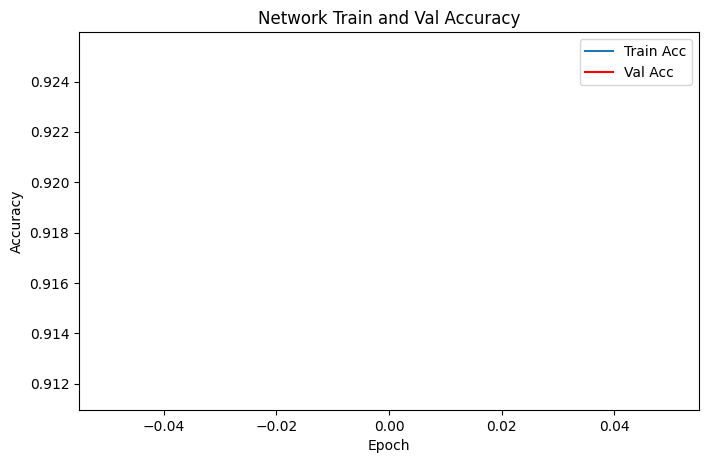

4441/4441 - 10s - loss: 0.2303 - precision: 0.6587 - recall: 0.9743 - auc: 0.9670 - accuracy: 0.9127 - val_loss: 0.1862 - val_precision: 0.7473 - val_recall: 0.9809 - val_auc: 0.9786 - val_accuracy: 0.9271


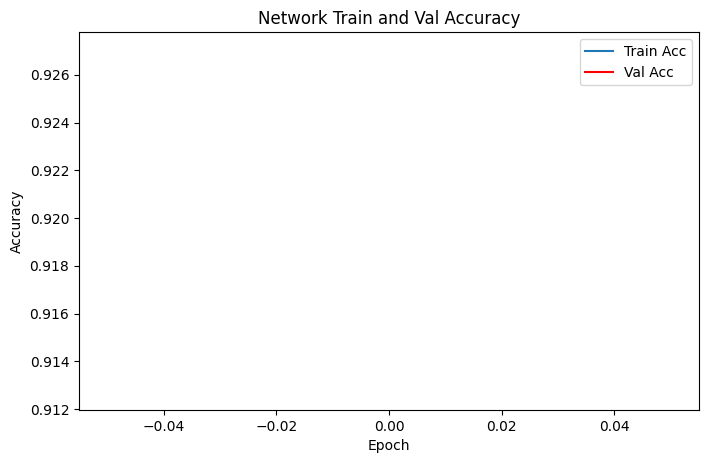

4441/4441 - 11s - loss: 0.2278 - precision: 0.6642 - recall: 0.9753 - auc: 0.9681 - accuracy: 0.9123 - val_loss: 0.1881 - val_precision: 0.7207 - val_recall: 0.9832 - val_auc: 0.9783 - val_accuracy: 0.9258


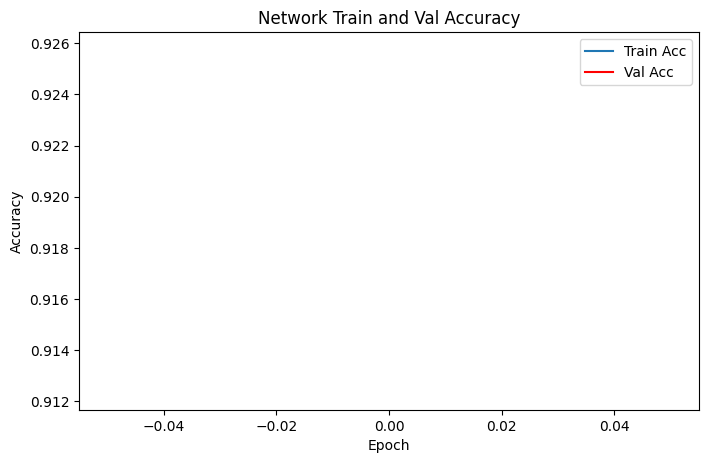

4441/4441 - 11s - loss: 0.2261 - precision: 0.6656 - recall: 0.9752 - auc: 0.9682 - accuracy: 0.9142 - val_loss: 0.1893 - val_precision: 0.7601 - val_recall: 0.9784 - val_auc: 0.9782 - val_accuracy: 0.9258


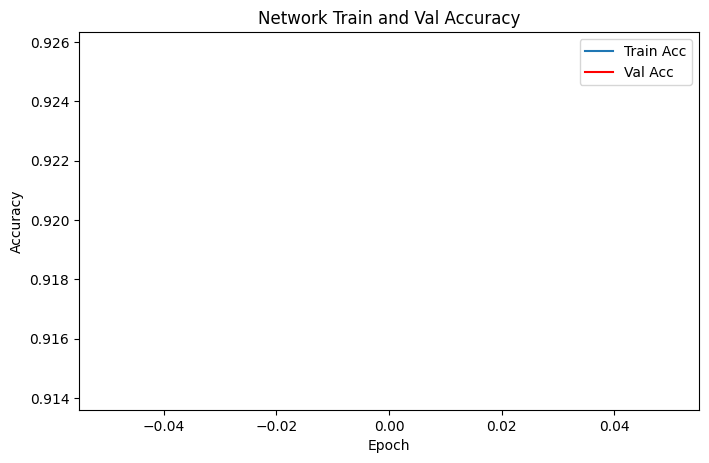

4441/4441 - 12s - loss: 0.2218 - precision: 0.6730 - recall: 0.9760 - auc: 0.9696 - accuracy: 0.9156 - val_loss: 0.1812 - val_precision: 0.7721 - val_recall: 0.9798 - val_auc: 0.9799 - val_accuracy: 0.9279


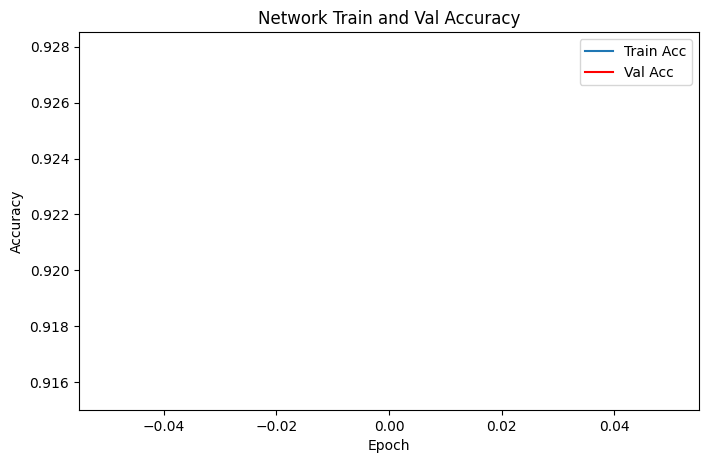

In [223]:
num_models = 5
ensemble = []

batch_size = 128
epochs = 1

input_shape = np.shape(x_train[0])

print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train[:,1] == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test[:,1] == 0.0) / len(y_test):.1f}")

for i in range(num_models):
    model = keras.Sequential([
                keras.Input(shape=input_shape),
                layers.Conv1D(16, kernel_size=(3), activation="relu"),
                #layers.MaxPooling2D(pool_size=(2)),
                layers.Conv1D(32, kernel_size=(3), activation="relu"),
                #layers.MaxPooling2D(pool_size=(2)),
                layers.Flatten(),
                layers.Dense(32, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dropout(0.2),
                layers.Dense(num_classes, activation="softmax")])
    
    model.compile(loss="binary_crossentropy", 
                  optimizer="adam", 
                  metrics=[keras.metrics.Recall(thresholds=(0.9), name='precision'), 
                           keras.metrics.Precision(thresholds=(0.9), name='recall'),
                           keras.metrics.AUC(curve='PR', name='auc'),
                           "accuracy"])

    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data = (x_test, y_test),
              verbose = 2
             )
    
    plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
    plt.plot(model.history.history['accuracy'], label='Train Acc')
    plt.plot(model.history.history['val_accuracy'], c='r', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Network Train and Val Accuracy')
    plt.show()
    
    ensemble.append(model)

In [224]:
output_dir = '../models/01-10-2020_ensemble_10_epoch'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for index, model in enumerate(ensemble):
    model.save(os.path.join(output_dir, 'model_' + str(index) + '.h5'))

## Load Ensemble

In [233]:
ensemble = []
model_dir = '../models/01-09-2020_ensemble'
for model in os.listdir(model_dir):
    ensemble.append(keras.models.load_model(os.path.join(model_dir, model)))
print(len(ensemble), 'models loaded')

21 models loaded


## Make Ensemble Predictions

In [119]:
import sys
sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

In [121]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.0075
site_coords = [115.350242, -8.562121]
name = 'temesi'

In [122]:
patch_history = get_history([site_coords], 
                            [name], 
                            rect_width,
                            num_months = 24,
                            start_date = '2019-01-01')

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:02<00:48,  2.10s/it]

  8%|▊         | 2/24 [00:04<00:45,  2.06s/it]

 12%|█▎        | 3/24 [00:05<00:39,  1.90s/it]

 17%|█▋        | 4/24 [00:07<00:38,  1.91s/it]

 21%|██        | 5/24 [00:09<00:35,  1.86s/it]

 25%|██▌       | 6/24 [00:10<00:32,  1.80s/it]

 29%|██▉       | 7/24 [00:13<00:32,  1.93s/it]

 33%|███▎      | 8/24 [00:15<00:32,  2.03s/it]

 38%|███▊      | 9/24 [00:20<00:45,  3.05s/it]

 42%|████▏     | 10/24 [00:26<00:52,  3.73s/it]

 46%|████▌     | 11/24 [00:28<00:41,  3.20s/it]

 50%|█████     | 12/24 [00:29<00:32,  2.70s/it]

 54%|█████▍    | 13/24 [00:32<00:30,  2.78s/it]

 58%|█████▊    | 14/24 [00:34<00:26,  2.63s/it]

 62%|██████▎   | 15/24 [00:36<00:21,  2.39s/it]

 67%|██████▋   | 16/24 [00:39<00:19,  2.38s/it]

 71%|███████   | 17/24 [00:44<00:23,  3.35s/it]

 75%|███████▌  | 18/24 [00:47<00:18,  3.07s/it]

 79%|███████▉  | 19/24 [00:50<00:15,  3.16s/it]

 83%|████████▎ | 20/24 [00:52<00:11,  2.90s/it]

 88%|████████▊ | 21/24 [00:55<00:08,  2.94s/it]

 92%|█████████▏| 22/24 [00:58<00:05,  2.86s/it]

 96%|█████████▌| 23/24 [01:01<00:02,  2.98s/it]

100%|██████████| 24/24 [01:05<00:00,  2.72s/it]


In [123]:
def normalize(array):
    return np.array(array) / 3000

def predict_time_series(patch_histories, site_name, model):
    rgb_stack = []
    preds_stack = []
    dates_list = []
    
    dates = list(patch_histories.keys())
    for date in tqdm(dates):
        rgb = np.stack((patch_histories[date][site_name]['B4'],
                        patch_histories[date][site_name]['B3'],
                        patch_histories[date][site_name]['B2']), axis=-1)
        
        width, height = rgb.shape[:2]
        pixel_vectors = []
        for i in range(width):
            for j in range(height):
                pixel_vector = []
                band_lengths = [len(patch_history[date][site_name][band]) for band in band_descriptions]
                if np.array(band_lengths).all() > 0:
                    for band in band_descriptions:
                        pixel_vector.append(patch_histories[date][site_name][band][i][j])
                    pixel_vectors.append(pixel_vector)
        
        pixel_vectors = normalize(pixel_vectors)
        if len(pixel_vectors) > 0 and np.median(rgb) > 0.1:
            rgb_stack.append(normalize(rgb))
            preds = model.predict(np.expand_dims(pixel_vectors, axis=-1))
            preds_img = np.reshape(preds, (width, height, 2))[:,:,1]
            preds_stack.append(preds_img)
            dates_list.append(date)
            
    return np.array(rgb_stack), np.array(preds_stack), dates_list

In [234]:
preds = []
for model in ensemble:
    rgb_stack, preds_stack, dates_list = predict_time_series(patch_history, 'temesi', model)
    preds.append(preds_stack)

100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


In [235]:
rgb_stack, preds_stack, dates_list = predict_time_series(patch_history, 'temesi', keras.models.load_model('../models/65_mo_tpa_bootstrap_toa-12-20-2020.h5'))


100%|██████████| 24/24 [00:10<00:00,  2.31it/s]


In [236]:
threshold = 0.5

/Users/ckruse/.envs/plastics/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


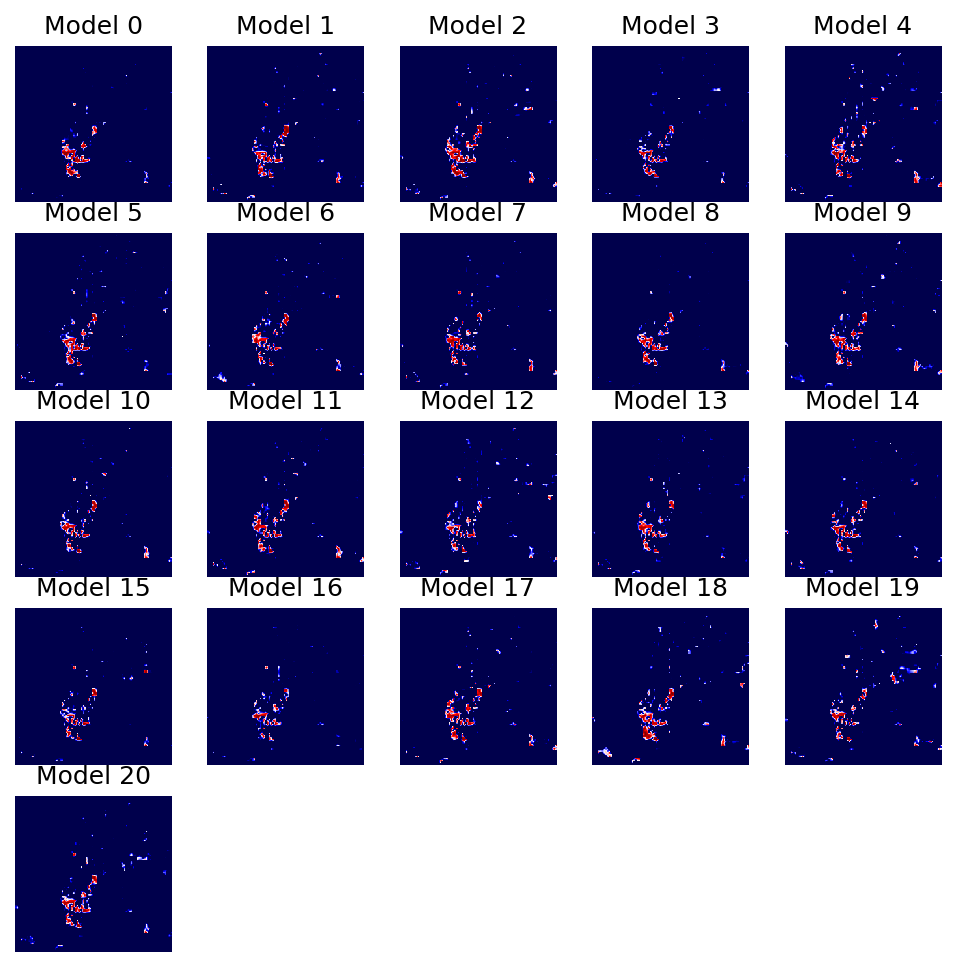

In [237]:
month = -2
plt.figure(figsize=(8,8), dpi=150)
for index, model_output in enumerate(preds):
    plt.subplot(np.ceil(np.sqrt(len(ensemble))),np.ceil(np.sqrt(len(ensemble))),index + 1)
    plt.title('Model ' + str(index))
    plt.imshow(model_output[month], vmin=0.5, vmax=1, cmap='seismic')
    plt.axis('off')
plt.show()

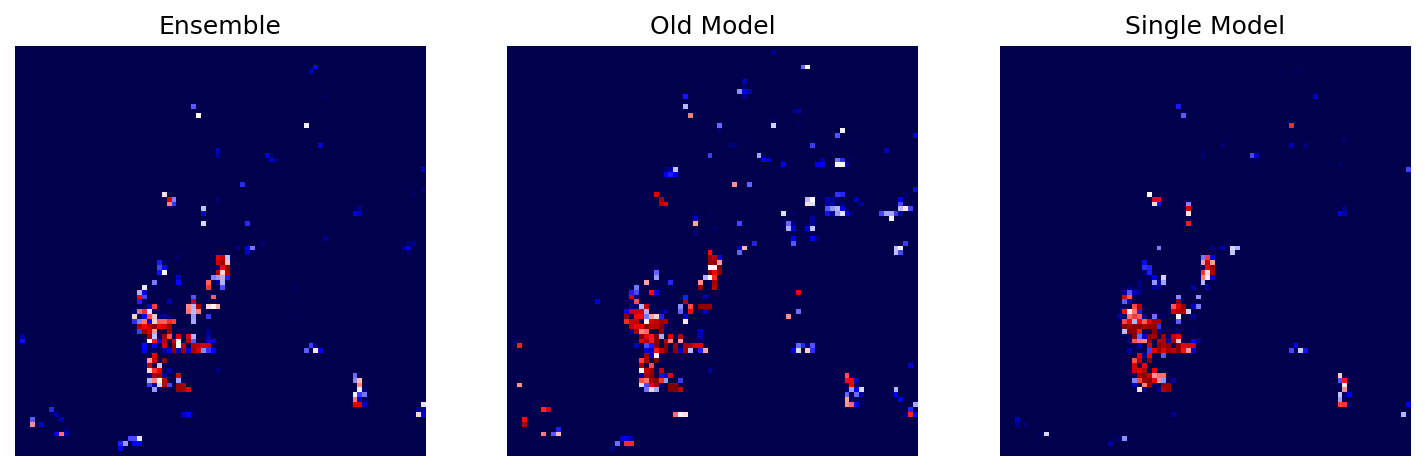

In [238]:
mean_pred = np.mean(preds, axis=0)
plt.figure(figsize=(12,4), dpi=150)
plt.subplot(1,3,1)
plt.title('Ensemble')
plt.imshow(mean_pred[month], vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Old Model')
plt.imshow(preds_stack[month], vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Single Model')
plt.imshow(preds[0][month], vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.show()

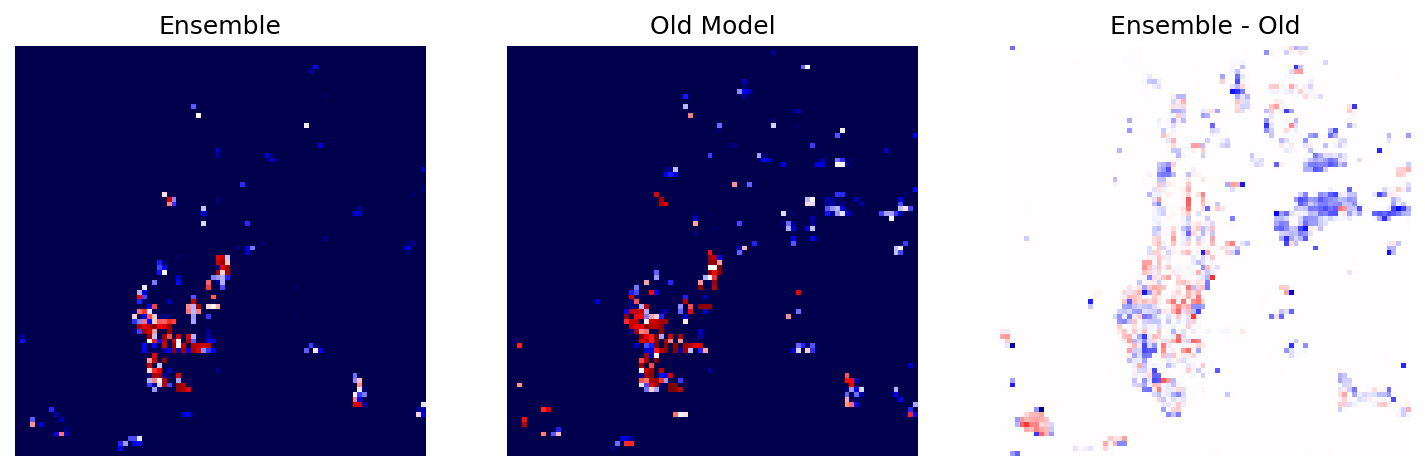

In [239]:
plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,3,1)
plt.title('Ensemble')
plt.imshow(np.clip(mean_pred[month], threshold,1), vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Old Model')
plt.imshow(np.clip(preds_stack[month], threshold,1), vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Ensemble - Old')
plt.imshow(mean_pred[month] - preds_stack[month], vmin=-1, vmax=1, cmap='seismic')
plt.axis('off')

plt.show()

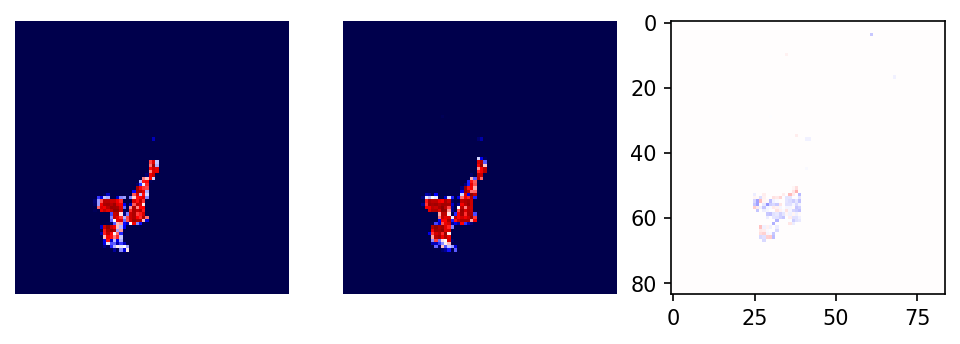

In [240]:
plt.figure(figsize=(8,4), dpi=150)
plt.subplot(1,3,1)
plt.imshow(np.clip(np.median(mean_pred[-12:], axis=0), threshold, 1), vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.clip(np.median(preds_stack[-12:], axis=0), threshold, 1), vmin=threshold, vmax=1, cmap='seismic')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.clip(np.median(mean_pred, axis=0), threshold,1) - np.clip(np.median(preds_stack, axis=0), threshold,1), vmin=-1, vmax=1, cmap='seismic')
plt.show()